In [35]:
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
#to predictive A
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

## Prophet으로 시계열 예측
- prophet : 시계열 데이터를 분석할 수 있는 패키지. facebook에서 만들었다.

In [36]:
df=pd.read_csv('sales_data.csv',encoding='unicode_escape')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
338919,566571,23390,DOLLY GIRL MINI BACKPACK,4.0,9/13/2011 12:49,4.15,17037.0,United Kingdom
338920,566571,22949,36 DOILIES DOLLY GIRL,12.0,9/13/2011 12:49,1.45,17037.0,United Kingdom
338921,566571,22138,BAKING SET 9 PIECE RETROSPOT,3.0,9/13/2011 12:49,4.95,17037.0,United Kingdom
338922,566571,23203,JUMBO BAG VINTAGE DOILY,10.0,9/13/2011 12:49,2.08,17037.0,United Kingdom


# Prophet
- 변수가 필요 없다. 실제 예측할 값과 시계열 데이터만 있으면 예측 가능
- 시계열과 예측값을 만드는데 특정 칼럼으로 만들어야 한다.
- 시계열 데이터 컬럼 ds 예측값은 y로 설정

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338924 entries, 0 to 338923
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    338924 non-null  object 
 1   StockCode    338924 non-null  object 
 2   Description  337739 non-null  object 
 3   Quantity     338923 non-null  float64
 4   InvoiceDate  338923 non-null  object 
 5   UnitPrice    338923 non-null  float64
 6   CustomerID   246728 non-null  float64
 7   Country      338923 non-null  object 
dtypes: float64(3), object(5)
memory usage: 20.7+ MB


In [38]:
# InvoiceDate 칼럼을 datetime 형식으로
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338924 entries, 0 to 338923
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    338924 non-null  object        
 1   StockCode    338924 non-null  object        
 2   Description  337739 non-null  object        
 3   Quantity     338923 non-null  float64       
 4   InvoiceDate  338923 non-null  datetime64[ns]
 5   UnitPrice    338923 non-null  float64       
 6   CustomerID   246728 non-null  float64       
 7   Country      338923 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 20.7+ MB


# 간단한 전처리 진행

In [40]:
df_1 = df.copy()

# 주문 데이터의 수량이 -인 경우 존재 => 반품
# -값은 날리고 +만 분석 진행
df_1=df_1[df_1.Quantity>0]
df_1=df_1[df_1.UnitPrice>0]

In [41]:
# ttp가 실제로 예측할 변수
df_1['ttp']= df_1['Quantity'] * df_1['UnitPrice']
df_1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ttp
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
338918,566571,22974,CHILDRENS DOLLY GIRL MUG,12.0,2011-09-13 12:49:00,1.65,17037.0,United Kingdom,19.80
338919,566571,23390,DOLLY GIRL MINI BACKPACK,4.0,2011-09-13 12:49:00,4.15,17037.0,United Kingdom,16.60
338920,566571,22949,36 DOILIES DOLLY GIRL,12.0,2011-09-13 12:49:00,1.45,17037.0,United Kingdom,17.40
338921,566571,22138,BAKING SET 9 PIECE RETROSPOT,3.0,2011-09-13 12:49:00,4.95,17037.0,United Kingdom,14.85


In [42]:
df_psp = df_1[['InvoiceDate','ttp']]
# InvoiceDate를 ds로, ttp를 y로 설정!
df_psp.rename(columns = {'InvoiceDate':'ds','ttp':'y'}, inplace = True)

In [43]:
df_psp

,ds,y
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34
...,...,...
338918,2011-09-13 12:49:00,19.80
338919,2011-09-13 12:49:00,16.60
338920,2011-09-13 12:49:00,17.40
338921,2011-09-13 12:49:00,14.85


## 일별 주문량으로 정리하여 데이터프레임 만들자

In [44]:
df_psp = df_psp.set_index("ds")
df_f = df_psp.resample('D')['y'].sum()

In [45]:
df_f = df_f.to_frame()
df_f

,y
ds,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95
...,...
2011-09-09,30075.62
2011-09-10,0.00
2011-09-11,35511.67


<Axes: xlabel='ds'>

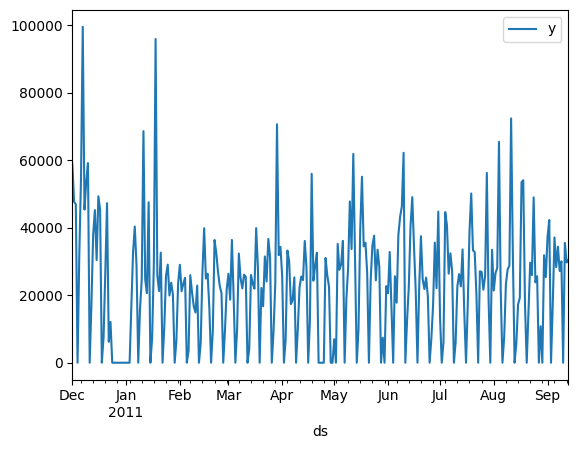

In [46]:
df_f.plot()

- 2010년 12월 ~ 2011년 12월까지 점점 우상향 경향
- 자기가 알아서 계절성 잡아주고, 추세 트렌드 확인 후 예측해준다


In [47]:
df_f.reset_index(inplace = True) # 인덱스를 다시 풀어서 두 컬럼으로 만든다
df_f

,ds,y
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-04,0.00
4,2010-12-05,31774.95
...,...,...
282,2011-09-09,30075.62
283,2011-09-10,0.00
284,2011-09-11,35511.67
285,2011-09-12,29738.33


In [56]:
#train, test set 나누기
# train 데이터를 가지고 미래 30일을 예측하여 test 데이터와 비교해서 실제 값이 어떤지 확인한다

train=df_f[:240]
test = df_f[240:] #시계열 데이터는 shuffle 하지 않는다.

In [57]:
train

,ds,y
0,2010-12-01,58960.790
1,2010-12-02,47748.380
2,2010-12-03,46943.710
3,2010-12-04,0.000
4,2010-12-05,31774.950
...,...,...
235,2011-07-24,27099.460
236,2011-07-25,26887.150
237,2011-07-26,21644.261
238,2011-07-27,25602.930


# prophet에 들어가는 하이퍼파라미터 다 정리
- 실제 값을 넣어서 예측값이 변화하는 것을 확인하기( 코드 & 주석 필수 )

## 1. changepoint_prior_scale : 0.05 [default]
-추세에 따라 데이터를 유연하게 반영할 건지 추세에 유연하지 않게 반영할 건지 결정하는 parameter
-추세에 덜 유연하게 반영하려면 default 값인 0.05 보다 작게 설정
-추세에 유연하게 반영하려면 0.05 보다 크게 설정

-추가적으로 기준일에 전날까지 반영할 거면 lower_window = -1, upper_window = 0
-기준일에 다음날까지 반영하면 lower_window = 0, upper_window = 1

- changepoint_prior_scale = 0.01 로 설정

In [58]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear')
prophet.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/dc6phdbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/2lt2nkf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80149', 'data', 'file=/tmp/tmplueazx_e/dc6phdbf.json', 'init=/tmp/tmplueazx_e/2lt2nkf7.json', 'output', 'file=/tmp/tmplueazx_e/prophet_modeluawta3m7/prophet_model-20230702084918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:49:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:49:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [59]:
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)

In [63]:
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
ph_yhat

,ds,yhat
240,2011-07-29,25785.720844
241,2011-07-30,214.179435
242,2011-07-31,11779.753108
243,2011-08-01,26017.609200
244,2011-08-02,38281.070480
245,2011-08-03,26990.066215
246,2011-08-04,32872.850571
247,2011-08-05,25831.216731
248,2011-08-06,259.675322
249,2011-08-07,11825.248995


In [61]:
test

,ds,y
240,2011-07-29,18790.40
241,2011-07-30,0.00
242,2011-07-31,33490.61
243,2011-08-01,21388.92
244,2011-08-02,26580.60
245,2011-08-03,28113.14
246,2011-08-04,65502.21
247,2011-08-05,21538.58
248,2011-08-06,0.00
249,2011-08-07,7578.91


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28546.820925  13028.852698  44482.736786
1 2010-12-02  34383.483376  18573.008048  51159.681599
2 2010-12-03  27295.727631   9994.001726  43472.981036
3 2010-12-04   1678.064316 -14806.286483  16483.995847
4 2010-12-05  13197.516084  -3838.000529  29628.779065


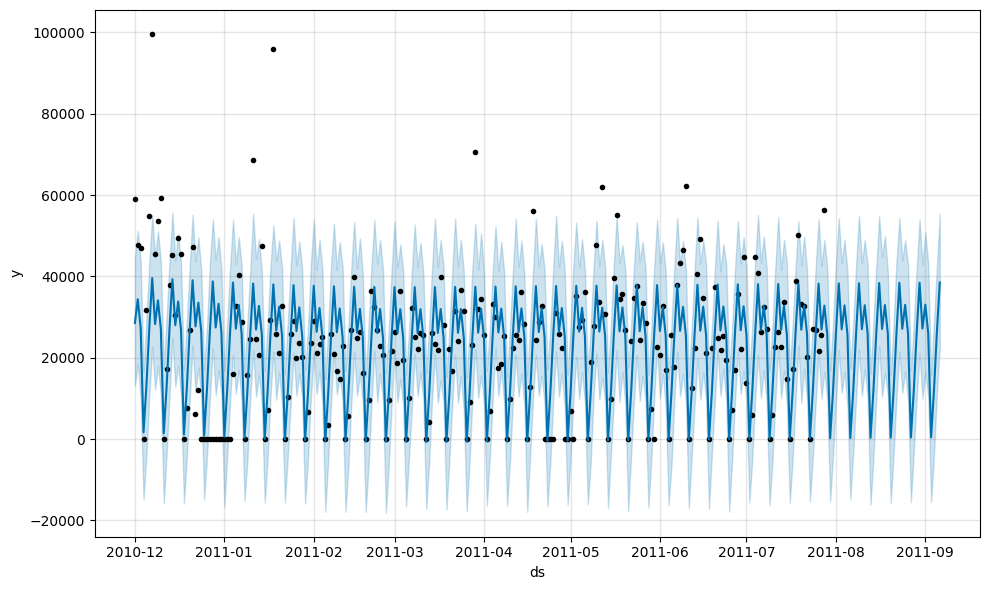

In [62]:
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

- changepoint_prior_scale = 0.001 로 설정

In [55]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear', changepoint_prior_scale = 0.01)
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/bv59hxzn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/l2ctlrj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65691', 'data', 'file=/tmp/tmplueazx_e/bv59hxzn.json', 'init=/tmp/tmplueazx_e/l2ctlrj3.json', 'output', 'file=/tmp/tmplueazx_e/prophet_model9j5mdbkv/prophet_model-20230702084820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:48:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28546.820925  13028.852698  44482.736786
1 2010-12-02  34383.483376  18573.008048  51159.681599
2 2010-12-03  27295.727631   9994.001726  43472.981036
3 2010-12-04   1678.064316 -14806.286483  16483.995847
4 2010-12-05  13197.516084  -3838.000529  29628.779065


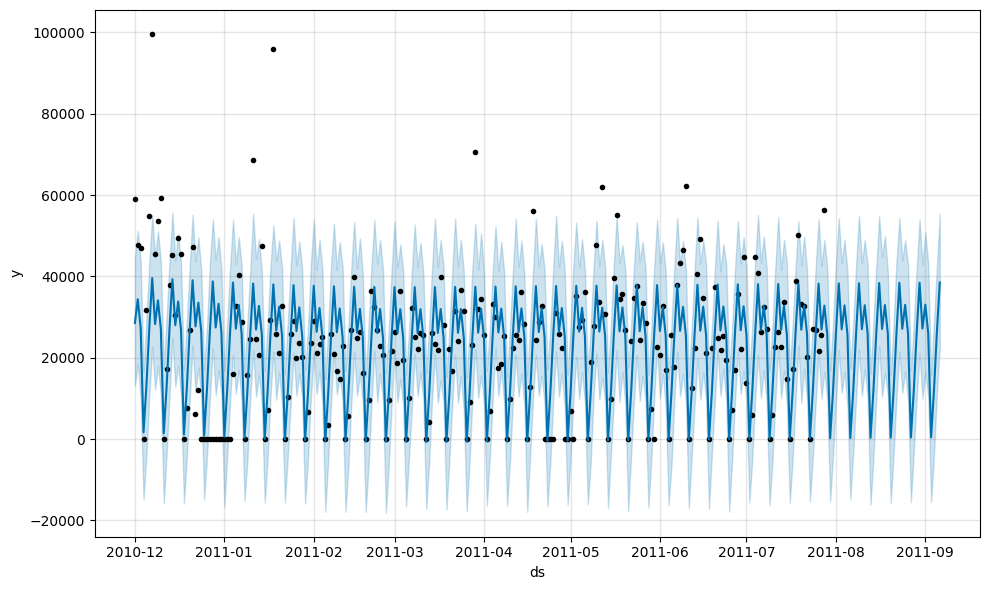

In [65]:
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

## seasonality_prior_scale : 10 [default]
- 계절의 유연성을 제어하는 parameter 값이 크면 계절성의 영향이 커지고 값이 작아지면 계절성의 영향이 줄어듦
합리적인 조정 범위는 [0.01,10] 사이

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/nrsxjo4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/u6p3lrfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15370', 'data', 'file=/tmp/tmplueazx_e/nrsxjo4k.json', 'init=/tmp/tmplueazx_e/u6p3lrfx.json', 'output', 'file=/tmp/tmplueazx_e/prophet_modelwuxj2eu8/prophet_model-20230702085233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:52:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:52:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  29188.354355  13515.786790  44167.689536
1 2010-12-02  34688.041047  18337.189361  49676.018392
2 2010-12-03  27985.719270  11080.718619  44375.123420
3 2010-12-04   3794.875794 -13139.639891  19263.719865
4 2010-12-05  14656.512061  -2493.318241  30392.445088


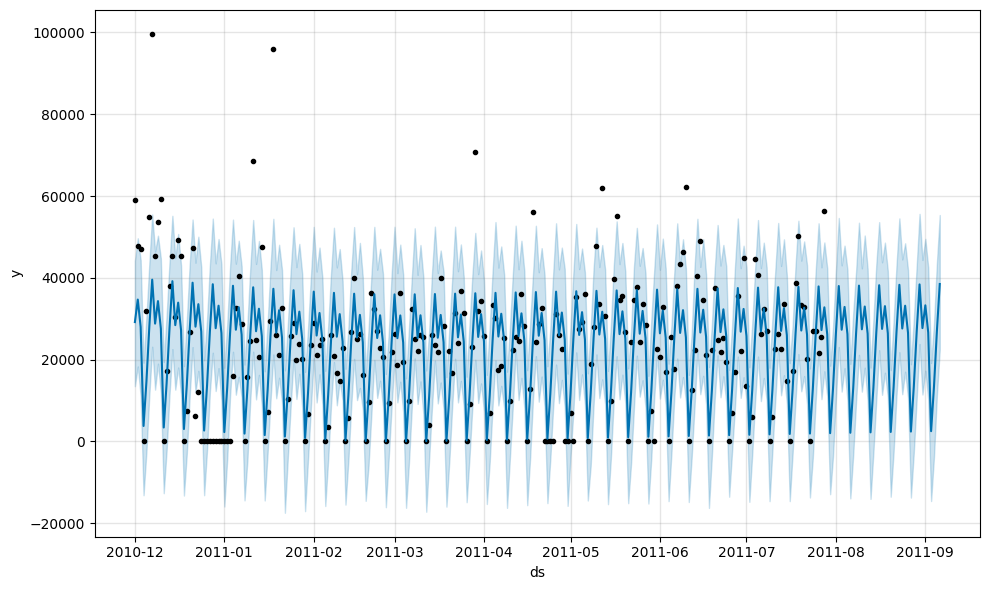

In [66]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear',seasonality_prior_scale = 0.05)
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/jm5x8lop.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/nobol2xw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54319', 'data', 'file=/tmp/tmplueazx_e/jm5x8lop.json', 'init=/tmp/tmplueazx_e/nobol2xw.json', 'output', 'file=/tmp/tmplueazx_e/prophet_modelz1i8qqwq/prophet_model-20230702085242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:52:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28493.635602  12093.363867  43517.815183
1 2010-12-02  34305.864767  17665.341066  50278.734201
2 2010-12-03  27249.362329  10725.259753  44135.456148
3 2010-12-04   1728.820036 -14562.949665  18042.544796
4 2010-12-05  13206.469596  -4121.319081  30535.654039


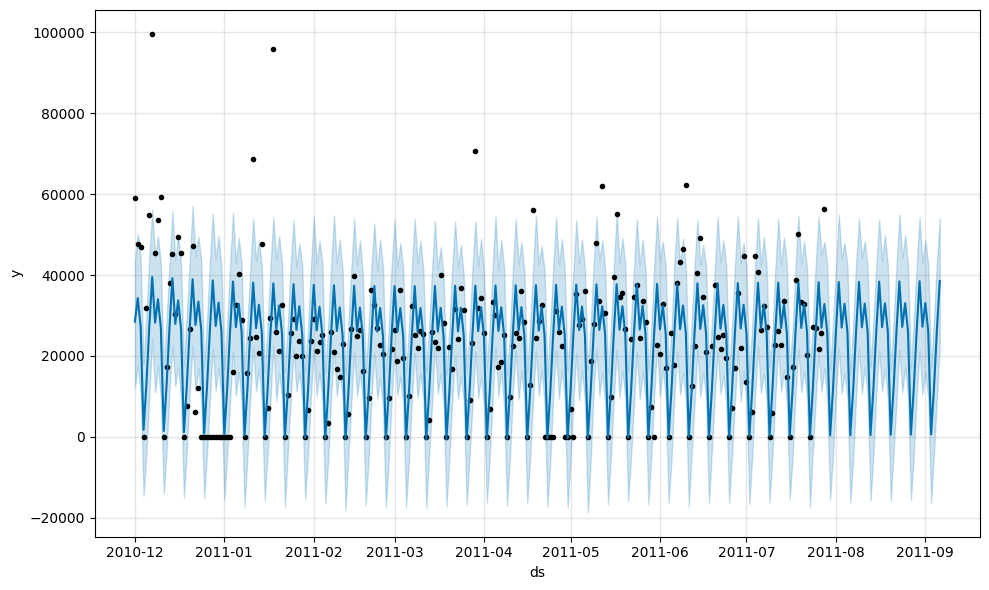

In [67]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear',seasonality_prior_scale = 5)
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

## holidays_prior_scale : 10.0 [default]
- 휴일의 영향에 따라 유연성을 조절하는 parameter
조절 범위는 [0.01,10]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/na0r3j4m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/t55s9ibt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3516', 'data', 'file=/tmp/tmplueazx_e/na0r3j4m.json', 'init=/tmp/tmplueazx_e/t55s9ibt.json', 'output', 'file=/tmp/tmplueazx_e/prophet_model1_k47u8r/prophet_model-20230702085403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:54:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:54:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28546.820925  11298.968111  45528.986603
1 2010-12-02  34383.483376  18051.133840  51879.667966
2 2010-12-03  27295.727631  11183.820255  44023.207803
3 2010-12-04   1678.064316 -14548.198384  18006.275410
4 2010-12-05  13197.516084  -3138.929357  28750.455669


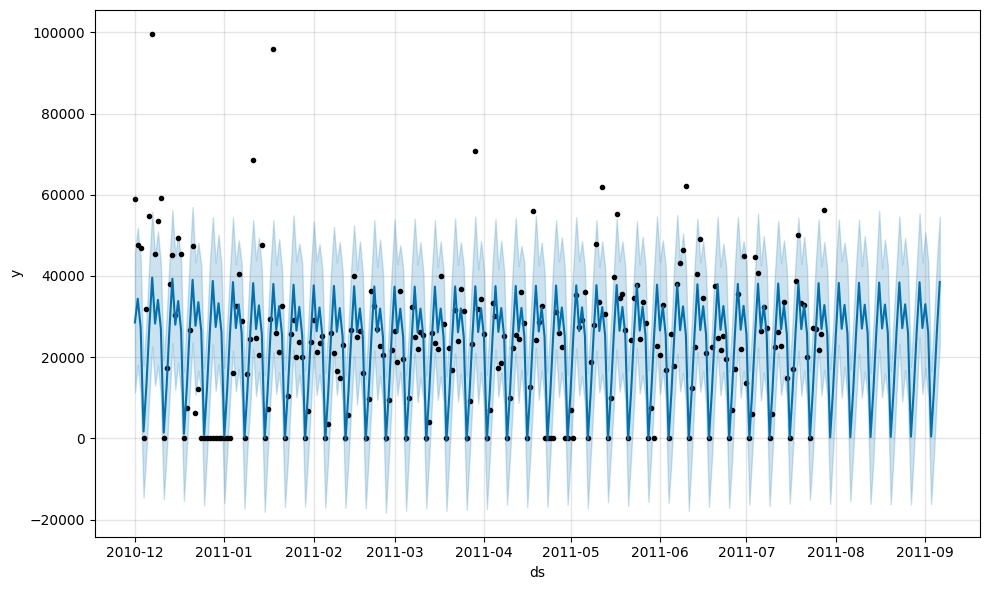

In [68]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear',holidays_prior_scale = 1)
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

## seasonality_mode : 'additive' [default]
- 옵션에는 ['addtive','multiflicative']
'addtive' : 시계열 데이터가 진폭이 일정할 때 사용
'multiflicative' : 시계열 데이터의 진폭이 점점 증가하거나 감소할 때 사용



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/97ofimty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/ryy15ugd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94623', 'data', 'file=/tmp/tmplueazx_e/97ofimty.json', 'init=/tmp/tmplueazx_e/ryy15ugd.json', 'output', 'file=/tmp/tmplueazx_e/prophet_modelvqmqbc4r/prophet_model-20230702085541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:55:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:55:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28546.820925  11562.998701  45026.713845
1 2010-12-02  34383.483376  19273.231485  51206.249168
2 2010-12-03  27295.727631  11622.767542  43602.683907
3 2010-12-04   1678.064316 -15363.111767  18918.275647
4 2010-12-05  13197.516084  -3412.102139  30132.559908


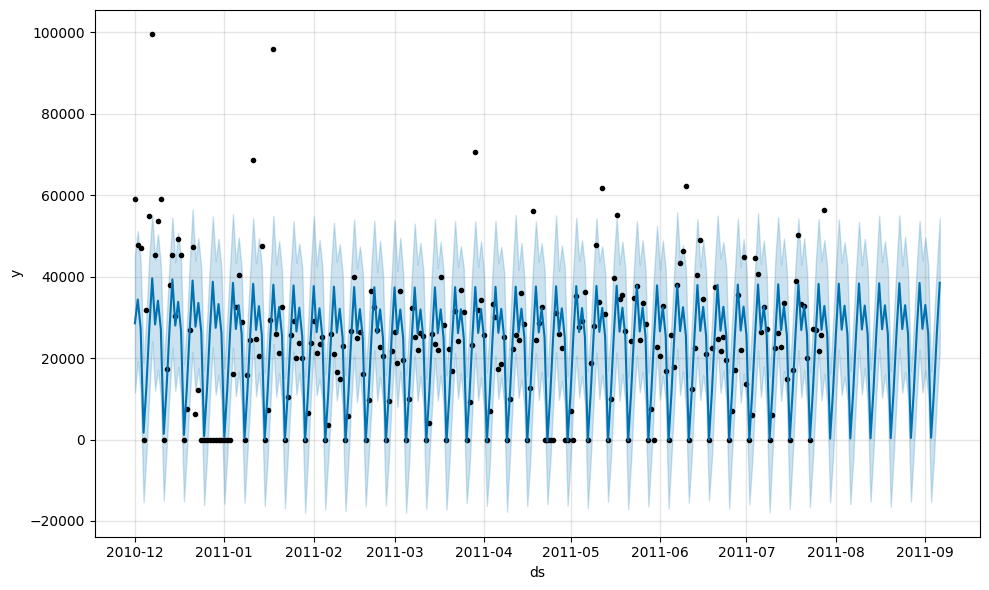

In [70]:
# additive 옵션 사용
prophet= Prophet(daily_seasonality = True, growth  = 'linear',seasonality_mode = 'additive')
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

##changepoint_range : 0.8 [default]

- change point의 설정 가능 범위를 의미
- 0.8 이면 데이터의 80% 중 changepoint를 자동으로 설정함
조절 범위 [0.8,0.95]



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/a0hrkyjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/yi_ocjwq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31476', 'data', 'file=/tmp/tmplueazx_e/a0hrkyjo.json', 'init=/tmp/tmplueazx_e/yi_ocjwq.json', 'output', 'file=/tmp/tmplueazx_e/prophet_model19ue1cty/prophet_model-20230702085711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:57:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:57:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28756.398223  13734.381915  44369.209135
1 2010-12-02  34553.524320  17605.351870  50498.225630
2 2010-12-03  27529.762126  11879.858777  44209.286307
3 2010-12-04   2053.534015 -15395.673923  18469.468366
4 2010-12-05  13515.885655  -4291.714411  30213.604121


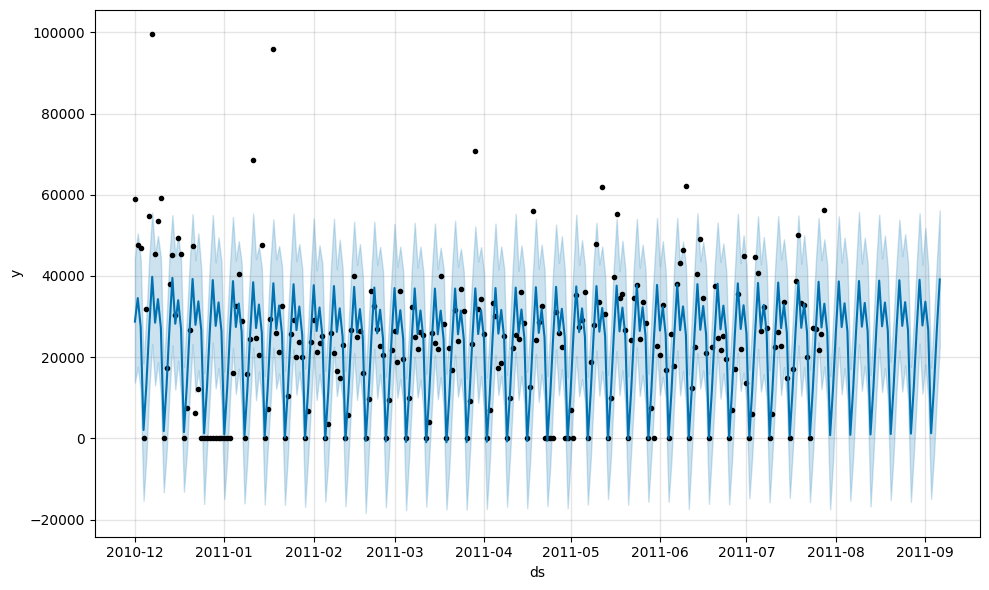

In [71]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear', changepoint_range = 0.5)
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

## growth : linear [default] 👍👍👍

- 옵션 [liner, logistic] 존재
- prophet logistic을 사용한다고 할 때는 cap, floor이라는 값을 설정
정해진 기준은 없고 모델을 돌리고 확인한 후에 설정하는 것을 추천



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/qoqnrkby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/_gjoz635.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36881', 'data', 'file=/tmp/tmplueazx_e/qoqnrkby.json', 'init=/tmp/tmplueazx_e/_gjoz635.json', 'output', 'file=/tmp/tmplueazx_e/prophet_model8bdo1kti/prophet_model-20230702085815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:58:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:58:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28546.820925  11787.104559  46034.126944
1 2010-12-02  34383.483376  18329.683398  50258.234931
2 2010-12-03  27295.727631  11307.842783  43962.587364
3 2010-12-04   1678.064316 -13828.608183  18840.244076
4 2010-12-05  13197.516084  -2508.204251  29448.229988


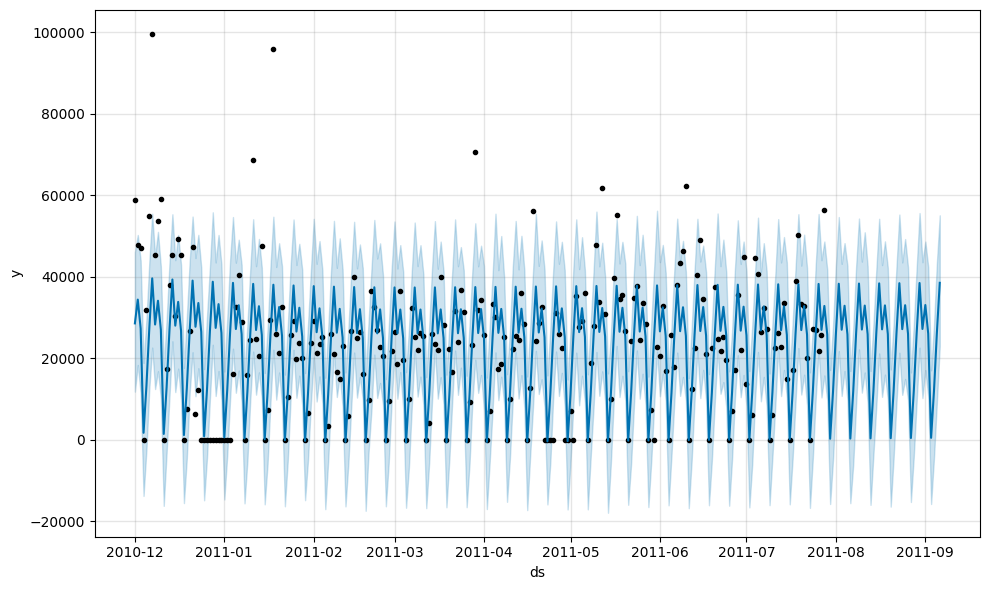

In [73]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear')
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

## n_changepoints : 25 [default]

- 자동으로 배치된 변경점의 수, 일반적인 시계열의 추세 변화를 파악하기 위해서 충분한 수로 설정해야 함.
- 변경점의 수를 늘리거나 줄이는 것보다 추세 변화에서 유연성을 변경하는 것이 더 효과적일 수 있음

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/9faae22n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/h5wzy1bx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11916', 'data', 'file=/tmp/tmplueazx_e/9faae22n.json', 'init=/tmp/tmplueazx_e/h5wzy1bx.json', 'output', 'file=/tmp/tmplueazx_e/prophet_modelwqlk7ny5/prophet_model-20230702085901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:59:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28545.263125  11992.121619  45342.416160
1 2010-12-02  34360.160571  18538.023026  50663.638814
2 2010-12-03  27304.500236  12535.082944  44234.693037
3 2010-12-04   1759.386902 -14302.857838  17940.595884
4 2010-12-05  13241.220576  -3269.040979  29449.783543


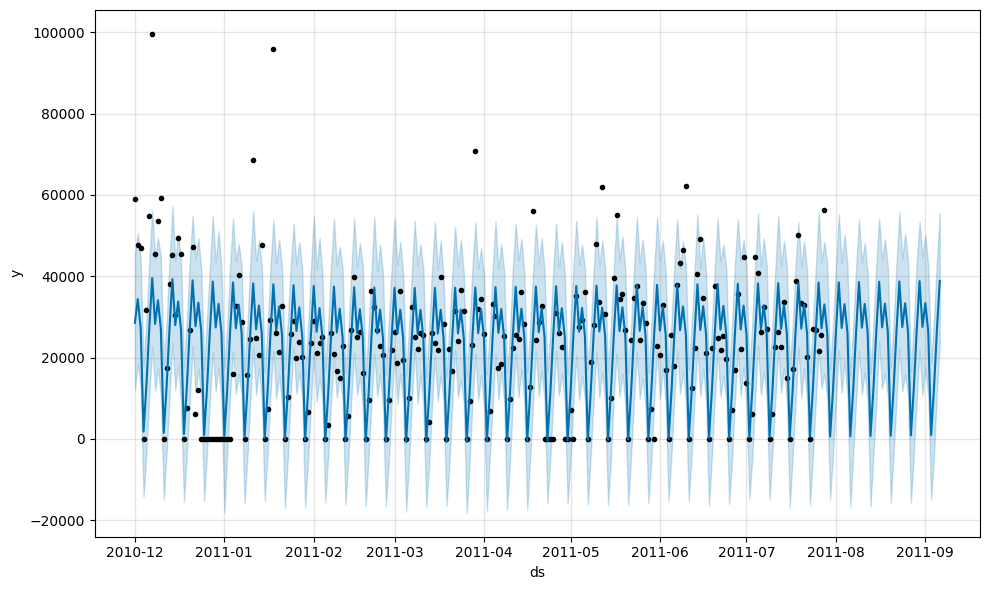

In [74]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear', n_changepoints = 20)
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

## yearly_seasonality : auto [default] 👍👍👍👍

- 데이터와 연간 계절성을 가지면 True 아니면 False로 설정 이와 같이 weekly_seasonality,daily_seasonality 존재
- 각각의 계절성이 보인다면 키고 seasonality_prior_scale을 조절하는 게 효과적

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/y4veonz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/p45hcbzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24869', 'data', 'file=/tmp/tmplueazx_e/y4veonz8.json', 'init=/tmp/tmplueazx_e/p45hcbzr.json', 'output', 'file=/tmp/tmplueazx_e/prophet_modelwjglo5lz/prophet_model-20230702090046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:00:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:00:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28892.047829  12001.643046  43324.626562
1 2010-12-02  34704.639173  18604.285272  50386.618466
2 2010-12-03  27642.021308  10790.459776  42468.313154
3 2010-12-04   2083.526503 -12671.689373  19444.226243
4 2010-12-05  13570.339129  -1820.879330  29370.486426


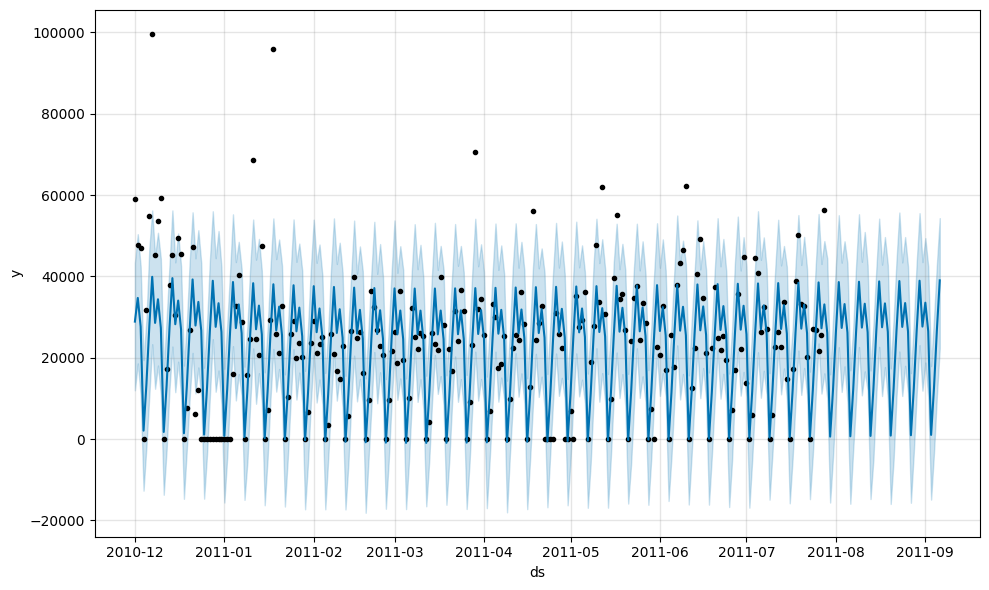

In [75]:
prophet= Prophet(weekly_seasonality = True, growth  = 'linear')
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

## holidays
- 지정된 공휴일의 데이터 프레임을 전달하기 위해서 사용
휴일 효과는 holidays_prior_scale을 통해서 조정

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/hh7pr_ai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/1_c8h78g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7097', 'data', 'file=/tmp/tmplueazx_e/hh7pr_ai.json', 'init=/tmp/tmplueazx_e/1_c8h78g.json', 'output', 'file=/tmp/tmplueazx_e/prophet_model2t0v59k4/prophet_model-20230702090216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28546.820925  13154.463244  44516.412587
1 2010-12-02  34383.483376  18619.536978  51413.901302
2 2010-12-03  27295.727631  11270.899480  43423.978518
3 2010-12-04   1678.064316 -14269.601359  18734.707476
4 2010-12-05  13197.516084  -2664.158128  30050.117831


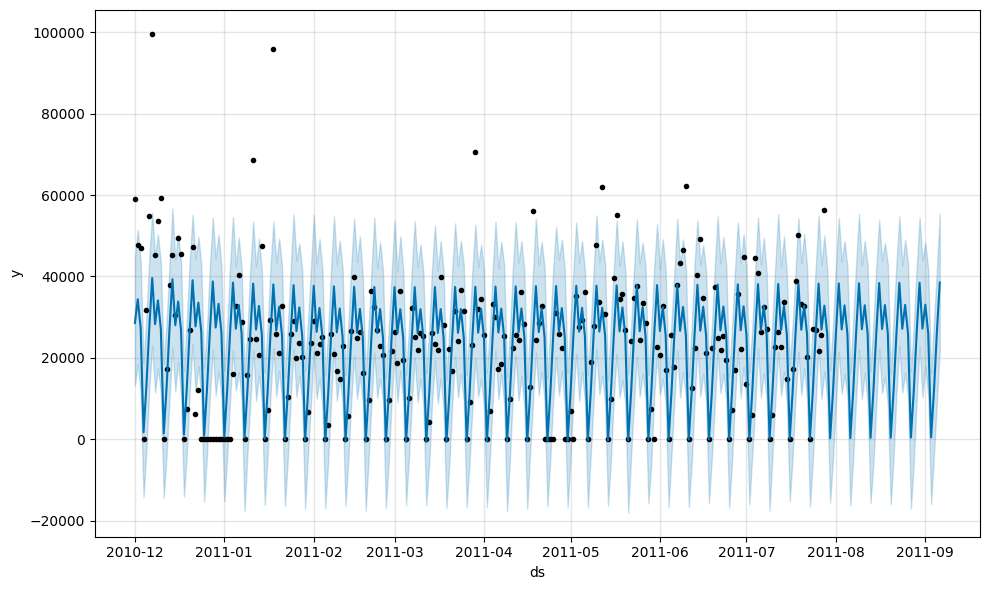

In [79]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear', holidays_prior_scale = '1')
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()

## interval_width : 0.8 [default]

- Prophet의 predict은 yhat_upper, yhat_lower 와 같은 불확실성 구간을 반환함
- 이것은 불확실성 구간에만 영향을 미치고 예측 yhat을 전혀 변경하지 않으므로 조정할 필요 없음

## uncertainty_samples : 1000 [default]

- 위와 같이 불확실성의 구간을 조정함

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/zp3ewr85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplueazx_e/ery99z96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23578', 'data', 'file=/tmp/tmplueazx_e/zp3ewr85.json', 'init=/tmp/tmplueazx_e/ery99z96.json', 'output', 'file=/tmp/tmplueazx_e/prophet_model878thwxa/prophet_model-20230702090330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  28546.820925  19409.630598  36094.311147
1 2010-12-02  34383.483376  26352.125170  43541.232055
2 2010-12-03  27295.727631  19680.590341  36986.215613
3 2010-12-04   1678.064316  -7631.719923  10577.095426
4 2010-12-05  13197.516084   3676.005828  21526.183650


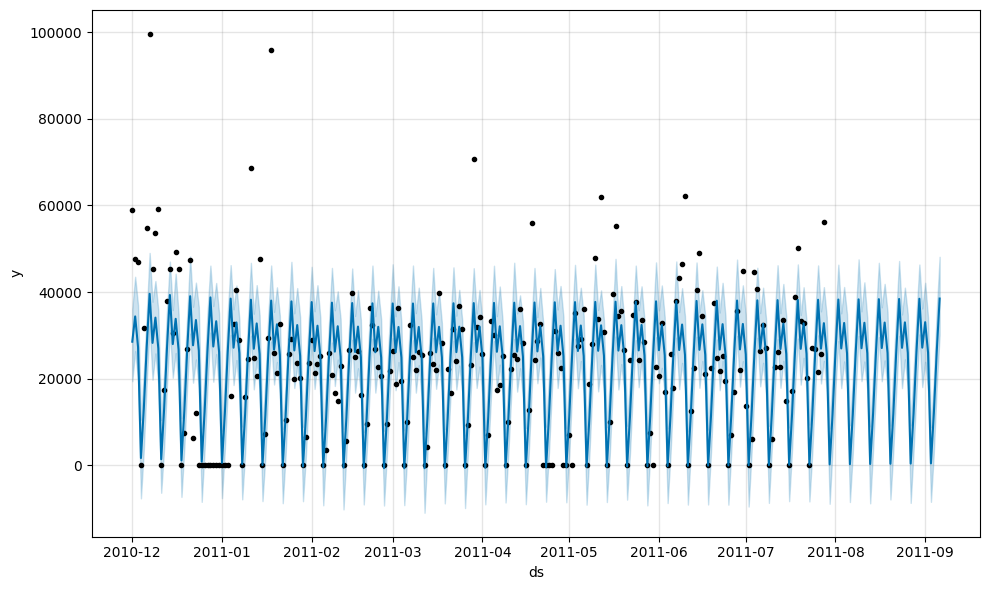

In [80]:
prophet= Prophet(daily_seasonality = True, growth  = 'linear', interval_width = 0.5)
prophet.fit(train)
# 이후의 기간 얼마나 예측해서 출력할 것 인가
future= prophet.make_future_dataframe(periods= 40)
forecast = prophet.predict(future)
ph_yhat = forecast[['ds','yhat']][240:] # 실제 예측한 값
#forecast 시각화
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())
#plot을 통한 시각화
prophet.plot(forecast)
plt.show()